# This notebook showcases the block-encoding of a sparse matrix.

AlmostTridiagonalRowColumnOracle encodes wich entries are non-zero in the sparse matrix that we are block-encoding.

In AlmostTridiagonalRowColumnOracle, for inputs $l=0$ and $i=0$, the output of the $l$ register is $-1$. Thus the $l$ register 'wraps around' and holds the value $2^{system bitsize} - 1$. Something similar is true for $l=2$ and $i=2^{system bitsize} - 1$. See the last output of this notebook for an example.

Hence the name 'AlmostTriadiagonal' and not 'Tridiagonal'.

In [9]:
from qualtran import BloqBuilder, SoquetT, QUInt
from qualtran.bloqs.arithmetic import Add, AddK
from qualtran.bloqs.block_encoding.sparse_matrix import RowColumnOracle
from qualtran.symbolics import SymbolicInt

from attrs import field, frozen
from functools import cached_property
from typing import *

@frozen
class AlmostTridiagonalRowColumnOracle(RowColumnOracle):

    system_bitsize: SymbolicInt
    _num_nonzero: SymbolicInt = field()

    @_num_nonzero.default
    def _num_nonzero_default(self):
        # At most 3 non-zero entries per row or column
        return min(3, 2**self.system_bitsize)

    @cached_property
    def num_nonzero(self) -> SymbolicInt:
        return self._num_nonzero

    def build_composite_bloq(self, bb: BloqBuilder, l: SoquetT, i: SoquetT) -> Dict[str, SoquetT]:

        i, l = bb.add(Add(QUInt(self.system_bitsize), QUInt(self.system_bitsize)), a=i, b=l)
        l = bb.add(AddK(self.system_bitsize, -1, signed=True), x=l) 

        return {"l": l, "i": i}


PlusDiagMinusNondiagEntryOracle specifies the entries of a matrix with +entry on the diagonal and -entry everywhere else.

In [6]:
from qualtran import Soquet, SoquetT, CtrlSpec
from qualtran.bloqs.basic_gates import Ry, XGate, ZGate
from qualtran.bloqs.block_encoding.sparse_matrix import EntryOracle
from qualtran.drawing import show_bloq

import numpy as np

@frozen
class PlusDiagMinusNondiagEntryOracle(EntryOracle):
    """Oracle specifying the entries of a matrix with +entry on the diagonal and -entry everywhere else."""

    system_bitsize: SymbolicInt
    entry: float

    def build_composite_bloq(
        self, bb: BloqBuilder, q: Soquet, **soqs: SoquetT
    ) -> Dict[str, SoquetT]:
        soqs["q"] = bb.add(Ry(2 * np.arccos(self.entry)), q=q)

        soqs["i"], soqs["j"] = bb.add(Add(QUInt(self.system_bitsize), QUInt(self.system_bitsize)).adjoint(), a=soqs["i"], b=soqs["j"])
        soqs["q"] = bb.add(XGate(), q=soqs["q"])

        ctrlOnInt0 = CtrlSpec(qdtypes=QUInt(self.system_bitsize), cvs=0)
        cz = ZGate().controlled(ctrl_spec=ctrlOnInt0)
        soqs["j"], soqs["q"] = bb.add(cz, ctrl=soqs["j"], q=soqs["q"])
        soqs["q"] = bb.add(ZGate(), q=soqs["q"])

        soqs["q"] = bb.add(XGate(), q=soqs["q"])
        soqs["i"], soqs["j"] = bb.add(Add(QUInt(self.system_bitsize), QUInt(self.system_bitsize)), a=soqs["i"], b=soqs["j"])
        
        return soqs



A block encoding $U$ of a sparse matrix $A$ is built from the row, column and entry oracles of $A$. 

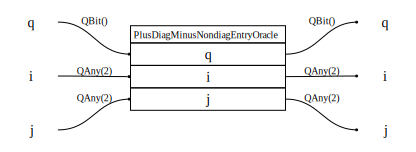

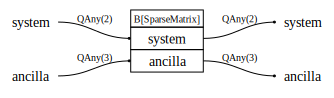

Block encoding (unitary matrix U):
 [[ 0.33333333 -0.22222222  0.11111111 ...  0.          0.
   0.        ]
 [-0.22222222  0.44444444 -0.22222222 ...  0.          0.
   0.        ]
 [ 0.11111111 -0.22222222  0.11111111 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.44444444 -0.22222222
   0.22222222]
 [ 0.          0.          0.         ... -0.22222222  0.11111111
  -0.11111111]
 [ 0.          0.          0.         ...  0.22222222 -0.11111111
   0.11111111]]


In [7]:
from qualtran.bloqs.block_encoding.sparse_matrix import SparseMatrix
from qualtran.drawing import show_bloq

system_bitsize = 2
row_oracle = AlmostTridiagonalRowColumnOracle(system_bitsize=system_bitsize)
col_oracle = AlmostTridiagonalRowColumnOracle(system_bitsize=system_bitsize)
entry_oracle = PlusDiagMinusNondiagEntryOracle(system_bitsize=system_bitsize, entry=1)
my_block_encoding = SparseMatrix(row_oracle, col_oracle, entry_oracle, eps=0)

# show_bloq(row_oracle, type='dtype')
# print(row_oracle.tensor_contract().real)

show_bloq(entry_oracle, type='dtype')
# print(entry_oracle.tensor_contract().real)

show_bloq(my_block_encoding, type='dtype')
# show_call_graph(my_block_encoding)
print('Block encoding (unitary matrix U):\n', my_block_encoding.tensor_contract().real)

$A$ is obtained from $U$ by tracing out the ancilla register. I.e. preparing the ancilla register in the $|0..0\rangle$ state and post-selecting on the ancilla register being measured in the $|0..0\rangle$ state.

In [8]:
from qualtran.bloqs.basic_gates import IntState, IntEffect
# import numpy as np

ancilla_bitsize = system_bitsize + 1

bb = BloqBuilder()
system = bb.add_register('system', system_bitsize)
ancilla = bb.add(IntState(val=0, bitsize=ancilla_bitsize))
system, ancilla = bb.add(my_block_encoding, system=system, ancilla=ancilla)
bb.add(IntEffect(val=0, bitsize=ancilla_bitsize), val=ancilla)

cbloq = bb.finalize(system=system)
# show_bloq(cbloq)
print('matrix A:\n', cbloq.tensor_contract().real)

matrix A:
 [[ 0.33333333 -0.33333333  0.         -0.33333333]
 [-0.33333333  0.33333333 -0.33333333  0.        ]
 [ 0.         -0.33333333  0.33333333 -0.33333333]
 [-0.33333333  0.         -0.33333333  0.33333333]]
